In [327]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [328]:
from dataio.genetics import GeneticDataset, GeneticOneHot
import pandas as pd
import torch
from model.utils import decode_onehot
import matplotlib.pyplot as plt
from model.ppnet import PPNet

In [329]:
# TRAIN_PATH = "datasets/genetics/small_diptera_family-train.tsv"
TRAIN_PATH = "datasets/genetics/large_diptera_family-train-species-Metriocnemus_augmented.tsv"

PUSH_PATH = "datasets/genetics/large_diptera_family-train-species-Metriocnemus_chopped.tsv"
# VALIDATION_PATH = "datasets/genetics/small_diptera_family-validation.tsv"
VALIDATION_PATH = "data/BIOSCAN-1M/large_diptera_family-validation.tsv"
# TAXONOMY_NAME = "family"
TAXONOMY_NAME = "species"
# PROTOTYPE_PATH = "saved_models/genetics/prototype_saving_test_images/epoch-80/genetic-string.csv"
# PROTOTYPE_PATH = "saved_models/genetics/prototype_saving_test_images/real_run/epoch-10/genetic-string.csv"
# WEIGHT_PATH = "saved_models/genetics/prototype_saving_test_images/real_run/10_push_weights.pth"
# PROTOTYPE_PATH = "saved_models/genetics/family_test_images/epoch-10/genetic-string.csv"
PROTOTYPE_PATH = "saved_models/genetics/metriocnemus_images/epoch-5/genetic-string.csv"
WEIGHT_PATH = "saved_models/genetics/metriocnemus/5_push1.0000.pth"
PROTOTYPE_COUNT = 20
CLASS_COUNT = 8
# CLASS_COUNT = 40

In [330]:
ppnet = torch.load(WEIGHT_PATH).to("cpu")

In [331]:
codon_map_a = {
    "Phe": ["TTT", "TTC"],
    "Leu": ["TTA", "TTG", "CTT", "CTC", "CTA", "CTG"],
    "Ile": ["ATT", "ATC", "ATA"],
    "Met": ["ATG"],
    "Val": ["GTT", "GTC", "GTA", "GTG"],
    "Ser": ["TCT", "TCC", "TCA", "TCG", "AGT", "AGC"],
    "Pro": ["CCT", "CCC", "CCA", "CCG"],
    "Thr": ["ACT", "ACC", "ACA", "ACG"],
    "Ala": ["GCT", "GCC", "GCA", "GCG"],
    "Tyr": ["TAT", "TAC"],
    "Stop": ["TAA", "TAG", "TGA"],
    "His": ["CAT", "CAC"],
    "Gln": ["CAA", "CAG"],
    "Asn": ["AAT", "AAC"],
    "Lys": ["AAA", "AAG"],
    "Asp": ["GAT", "GAC"],
    "Glu": ["GAA", "GAG"],
    "Cys": ["TGT", "TGC"],
    "Trp": ["TGG"],
    "Arg": ["CGT", "CGC", "CGA", "CGG", "AGA", "AGG"],
    "Gly": ["GGT", "GGC", "GGA", "GGG"],
    "None": ["NNN"],
}

codon_map = {}

for aa, codons in codon_map_a.items():
    for codon in codons:
        codon_map[codon] = aa

In [332]:
train_dataset = GeneticDataset(TRAIN_PATH,
                              "onehot", 
                              TAXONOMY_NAME,
                              max_class_count=CLASS_COUNT,
                              )

validation_dataset = GeneticDataset(VALIDATION_PATH, 
                              "onehot",
                              TAXONOMY_NAME,
                              train_dataset.get_classes(TAXONOMY_NAME)[0])

push_dataset = GeneticDataset(PUSH_PATH,
                                "onehot", 
                                TAXONOMY_NAME,
                                train_dataset.get_classes(TAXONOMY_NAME)[0],
                                )

In [333]:
prototype_df = pd.read_csv(PROTOTYPE_PATH)

In [334]:
prototype_df

,key,class_index,prototype_index,patch
0,0,0,0,TTATATTTTATTTTTGGA
1,1,0,1,GGCTTGATCAGGAATAGT
2,5,0,5,ATTGGGGACGACCAAATT
3,6,0,6,CTATAATGTAATTGTTAC
4,7,0,7,CAGCACATGCCTTTGTAA
...,...,...,...,...
315,316,7,36,NNNNNNNNNNNNNNNNNN
316,317,7,37,NNNNNNNNNNNNNNNNNN
317,318,7,38,NNNNNNNNNNNNNNNNNN
318,319,7,39,NNNNNNNNNNNNNNNNNN


In [335]:
prot_strings = [["" for j in range(0,40)] for i in range(0, 40)]

for i in range(0, len(prototype_df)):
    class_index = prototype_df.iloc[i]["class_index"]
    prototype_index = prototype_df.iloc[i]["prototype_index"]
    string = prototype_df.iloc[i]["patch"]

    prot_strings[class_index][prototype_index] = string

full_strings = ["".join(string) for string in prot_strings]

In [336]:
prototype_df

,key,class_index,prototype_index,patch
0,0,0,0,TTATATTTTATTTTTGGA
1,1,0,1,GGCTTGATCAGGAATAGT
2,5,0,5,ATTGGGGACGACCAAATT
3,6,0,6,CTATAATGTAATTGTTAC
4,7,0,7,CAGCACATGCCTTTGTAA
...,...,...,...,...
315,316,7,36,NNNNNNNNNNNNNNNNNN
316,317,7,37,NNNNNNNNNNNNNNNNNN
317,318,7,38,NNNNNNNNNNNNNNNNNN
318,319,7,39,NNNNNNNNNNNNNNNNNN


In [337]:
encoder = GeneticOneHot(include_height_channel=True)
tensors = [encoder(s) if s != "" else None for s in full_strings]

In [338]:
print(ppnet(tensors[0].unsqueeze(0))[1][0,0:40])

tensor([-0.9950, -0.9809, -0.9788, -0.9606, -0.9671, -0.8890, -0.9606, -0.9772,
        -0.9831, -0.9845, -0.9930, -0.8803, -0.9229, -0.9796, -0.9080, -0.9714,
        -0.8553, -0.9411, -0.9835, -0.9479, -0.9916, -0.9921, -0.9724, -1.0000,
        -1.0000, -0.9896, -0.9597, -0.8869, -0.9788, -0.8553, -0.8368, -0.9592,
        -1.0000, -0.9538, -0.9894, -0.9735, -0.9799, -1.0000, -1.0000, -1.0000])


In [339]:
def find_matching_dims(input_tensor, prototype_tensors, class_index):
    tensor = prototype_tensors[class_index]

    if tensor is None:
        print("No prototype tensor found for class index", class_index)
        return None
    
    if input_tensor.shape != tensor.shape:
        print("Shape mismatch for class index", class_index)
        return None
    
    output = torch.eq(input_tensor, tensor)
    # sum along the channel dimension
    output = output.sum(0)
    # integer divide by the number of channels
    output = output // 4
    return output[0]

In [340]:
# Open the weights
weights = ppnet.last_layer.weight

class_weights = torch.zeros(CLASS_COUNT, 40)

# Reshape the weights
weights = weights.reshape(CLASS_COUNT, CLASS_COUNT, 40)

for i in range(CLASS_COUNT):
    for j in range(40):
        class_weights[i][j] = weights[i][i][j]

In [341]:
sorted_prototype_indices = class_weights.argsort(descending=True, dim=1)
print(class_weights.sort(descending=True, dim=1))
print(sorted_prototype_indices)
best_prototypes = sorted_prototype_indices[:, :PROTOTYPE_COUNT]

torch.return_types.sort(
values=tensor([[1.0799, 1.0787, 1.0762, 1.0703, 1.0458, 1.0422, 1.0418, 1.0374, 1.0371,
         1.0361, 1.0358, 1.0339, 1.0322, 1.0312, 1.0299, 1.0287, 1.0270, 1.0259,
         1.0247, 1.0238, 1.0238, 1.0225, 1.0224, 1.0209, 1.0201, 1.0194, 1.0186,
         1.0126, 1.0126, 1.0123, 1.0110, 1.0109, 1.0102, 1.0080, 1.0059, 1.0059,
         1.0058, 0.9972, 0.9888, 0.9692],
        [1.0633, 1.0559, 1.0465, 1.0451, 1.0449, 1.0445, 1.0415, 1.0413, 1.0405,
         1.0381, 1.0359, 1.0354, 1.0351, 1.0347, 1.0325, 1.0325, 1.0320, 1.0318,
         1.0317, 1.0295, 1.0282, 1.0274, 1.0255, 1.0253, 1.0249, 1.0248, 1.0229,
         1.0177, 1.0168, 1.0157, 1.0141, 1.0104, 1.0045, 1.0045, 1.0043, 1.0027,
         0.9996, 0.9884, 0.9843, 0.9380],
        [1.0746, 1.0624, 1.0608, 1.0601, 1.0595, 1.0593, 1.0586, 1.0585, 1.0580,
         1.0565, 1.0539, 1.0521, 1.0438, 1.0438, 1.0411, 1.0391, 1.0325, 1.0294,
         1.0287, 1.0287, 1.0282, 1.0274, 1.0273, 1.0268, 1.0263, 1.0228, 1

In [342]:
def create_amino(string):
    output = []
    print(string)

    for i in range(0, len(string), 3):
        s = string[i:i+3]
        if s in codon_map:
            output.append(codon_map[s])
        else:
            output.append("None")
    
    return output

In [343]:
gorp = ppnet(validation_dataset[0][0].unsqueeze(0))[1]
# Reshape to have first dimension 40

gorp = gorp.reshape(40, -1)

print(-gorp.mean(1))

tensor([0.9302, 0.9178, 0.7818, 0.8129, 0.9154, 0.8309, 0.7388, 0.7715, 0.8389,
        0.8442, 0.9077, 0.8753, 0.7809, 0.8162, 0.8912, 0.8944, 0.9050, 0.8650,
        0.8118, 0.9263, 0.8959, 0.8795, 0.8750, 0.8062, 0.9227, 0.8846, 0.8561,
        0.8683, 0.9345, 0.9403, 0.8591, 0.8600, 0.8660, 0.7963, 0.9545, 0.7783,
        0.7415, 0.7230, 0.7292, 0.8574])


In [344]:
def get_corresponding_strings(input_tensor, input_class_index, prototype_tensors, threshold, best_prototypes):
    best_prototypes = best_prototypes[input_class_index]
    act = -ppnet(input_tensor.unsqueeze(0))[1].reshape(CLASS_COUNT,-1)[input_class_index]

    output = []

    for p in best_prototypes:
        if act[p] > threshold:
            output.append((decode_onehot(prototype_tensors[input_class_index][:,:,p*18:(p+1)*18]), decode_onehot(input_tensor[:,:,p*18:(p+1)*18], True), float(act[p]), p))

    return output


In [345]:
def display_pair(prototype_string, input_string, act):
    print(input_string)
    for i, c in enumerate(prototype_string):
        plt.text(.05 * i+.05, 0.5, c, fontsize=18, ha='center', va='center')
        plt.text(.05 * i+.05, 0.4, input_string[i], fontsize=18, ha='center', va='center')
        # Color the squares based on whether the character matches the prototype
        if c == input_string[i]:
            plt.gca().add_patch(plt.Rectangle((.05 * i+.025, 0.35), .05, .2, fill=True, color='green'))
        else:
            plt.gca().add_patch(plt.Rectangle((.05 * i+.025, 0.35), .05, .2, fill=True, color='red'))

    # Resize plot image
    plt.gcf().set_size_inches(10, 2)
    plt.ylim(.35, .55)
    plt.xlim(.025, .925)

    # Hide plot axis
    plt.axis('off')
    plt.show()

CTCCTCAATGTTAGGGGC
tensor(1)
TTCTTTACCTGTATTAGC
0 0.9233847856521606 tensor(23)
TATCTCCTCAATGTTAGG


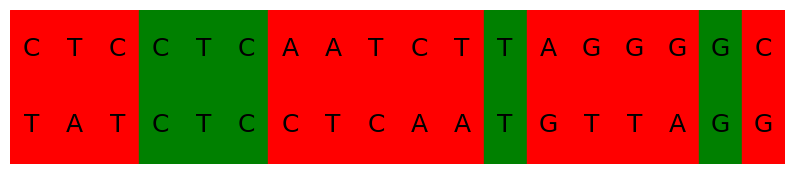

1 0.9781917333602905 tensor(16)
ATTATCTAGATCAATTGT


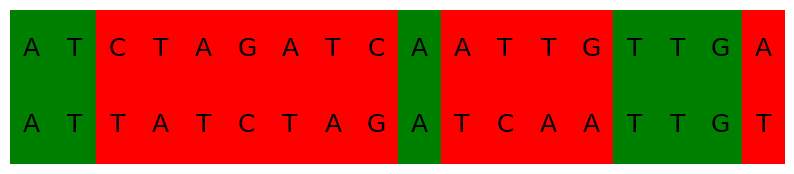

2 0.6447030901908875 tensor(36)
ACACTTATTTNNNNNNNN


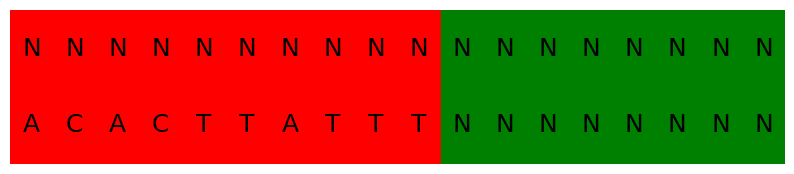

3 0.9805758595466614 tensor(28)
TGTCTGATCTGTAATTAT


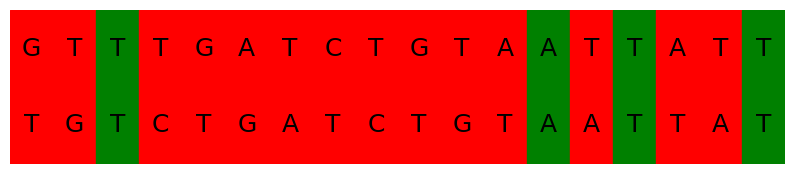

4 0.9778662323951721 tensor(21)
TGTTGATTTAGCTATTTT


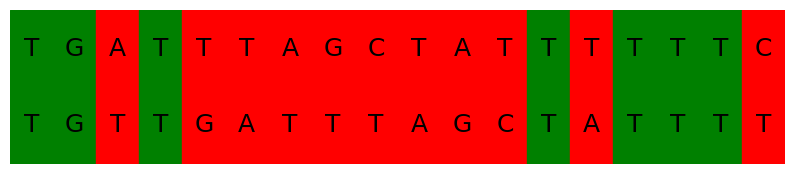

5 0.9225066900253296 tensor(17)
TGAAAATGGGGCTGGGAC


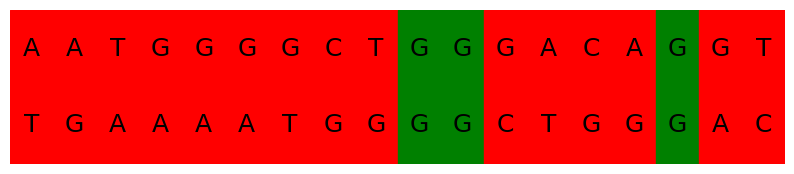

6 0.7630235552787781 tensor(26)
GTCAGAAGGAATTTCTTT


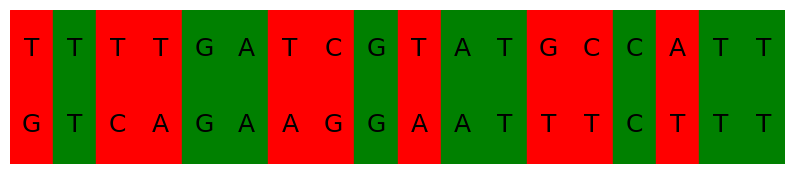

7 0.7464091777801514 tensor(15)
CCCTTCATTAACTTTATT


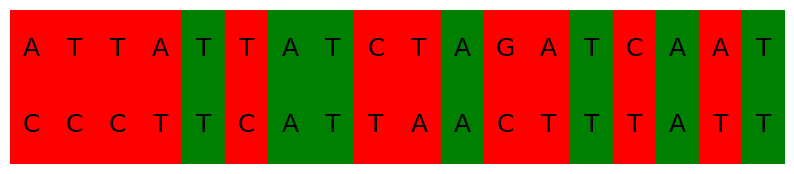

8 0.8027307391166687 tensor(2)
AGTAGGTACTTCTTTAAG


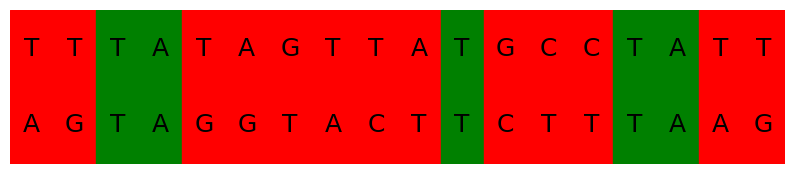

9 0.9632879495620728 tensor(25)
AACAGTAATTAATATACG


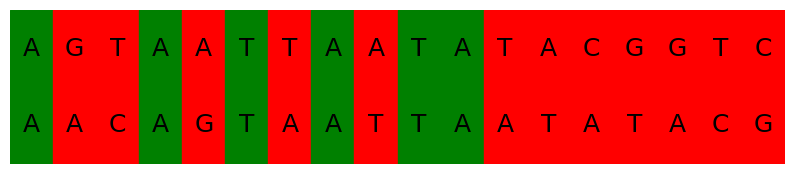

10 0.9276748299598694 tensor(18)
AGGTTGAACTGTTTACCC


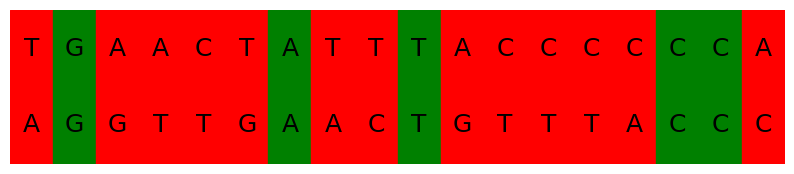

11 0.9744587540626526 tensor(3)
AATTTTAATTCGAGCAGA


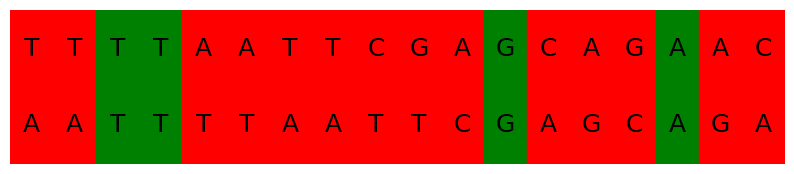

12 0.9390822649002075 tensor(33)
TTTAAATACTTCTTTCTT


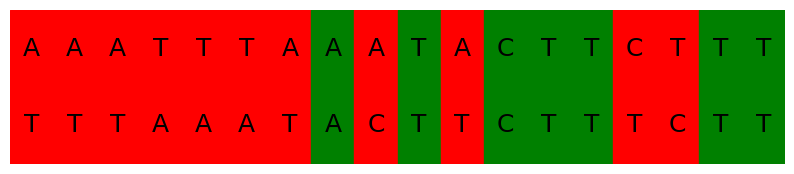

13 0.9242153763771057 tensor(24)
GGCTGTAAATTTTATCAC


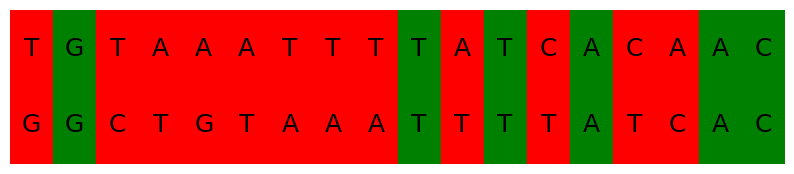

14 0.9698474407196045 tensor(27)
TGATCGTATGCCATTATT


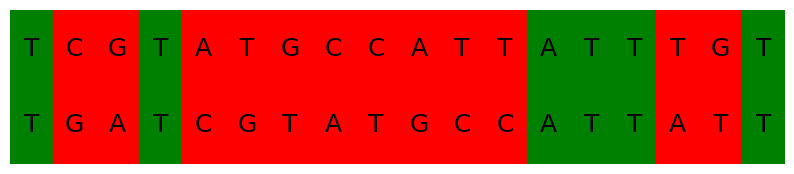

15 0.9520635604858398 tensor(22)
TTCATTACATTTAGCAGG


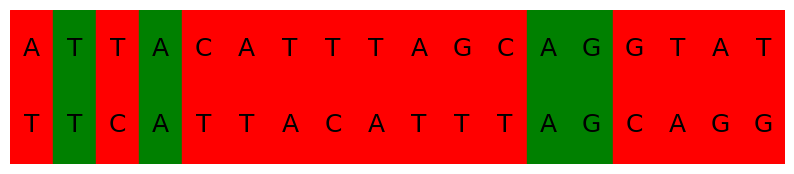

16 0.9391674399375916 tensor(10)
GGGATTTGGTAACTGATT


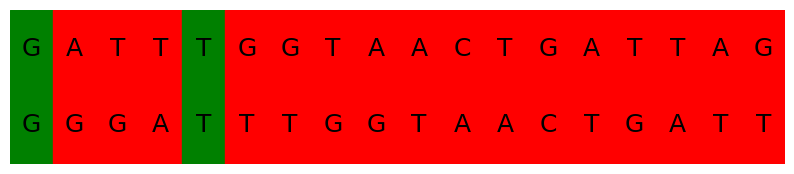

17 0.9663612246513367 tensor(31)
AGCAGGAGCAATCACTAT


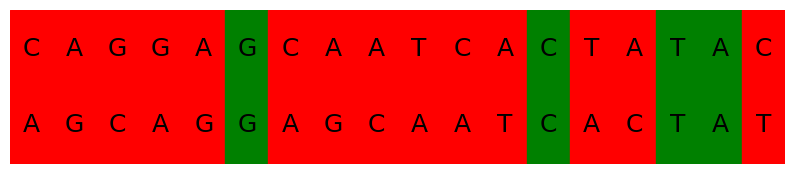

18 0.9999999403953552 tensor(14)
AAGATTCTGATTATTGCC


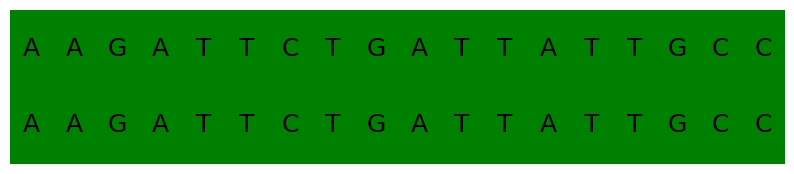

19 0.9469649791717529 tensor(32)
ACTTTTAACAGATCGAAA


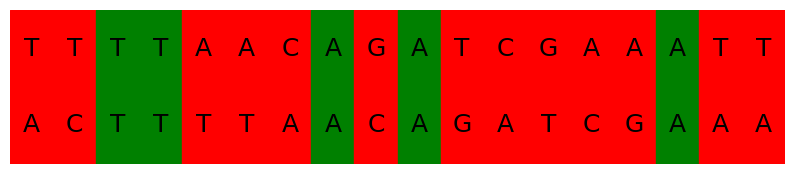

In [404]:
# o = get_corresponding_strings(validation_dataset[0][0], validation_dataset[0][1], tensors, 0, best_prototypes)

a = decode_onehot(push_dataset[7][0], True)
a2 = a[:426] + "G" + a[427:]
# a2 = a[:421] + "A" + a[422:]

o = get_corresponding_strings(encoder(a2), 1, tensors, 0, best_prototypes)
# o = get_corresponding_strings(push_dataset[7][0], 1, tensors, 0, best_prototypes)
# o = get_corresponding_strings(validation_dataset[0][0], 1, tensors, 0.5, best_prototypes)

print(a2[417:435])

print(push_dataset[7][1])

print(decode_onehot(validation_dataset[0][0], True)[30*18:31*18])

# print(validation_dataset[0][1])
# print(best_prototypes[0])

for idx, (p, i, a, p_2) in enumerate(o):
    print(idx, a, p_2)
    display_pair(p, i, 0)

# T - .906S
# A - .850
# C - Same
# G - .923

In [347]:
# for i in range(PROTOTYPE_COUNT):
#     string = decode_onehot(input_tensor[0].numpy(), three_dim=True)

#     # print(string[best_prototypes[9][i]*18:(best_prototypes[9][i]+1)*18])
#     # print("")

#     # Draw 18 squares each with one character of prot using matplotlib
#     prot = prot_strings[prototype_class_index][int(best_prototypes[prototype_class_index][i])]
#     corresponding = string[best_prototypes[prototype_class_index][i]*18:(best_prototypes[prototype_class_index][i]+1)*18]

#     # This only works since prototypes are length 0 mod 3
#     prot_amino = create_amino(prot)
#     string_amino = create_amino(corresponding)
#     print(prot_amino)
#     print(string_amino)

#     for i, c in enumerate(prot):
#         plt.text(.05 * i+.05, 0.5, c, fontsize=18, ha='center', va='center')
#         plt.text(.05 * i+.05, 0.4, corresponding[i], fontsize=18, ha='center', va='center')
#         # Color the squares based on whether the character matches the prototype
#         if c == corresponding[i]:
#             plt.gca().add_patch(plt.Rectangle((.05 * i+.025, 0.35), .05, .2, fill=True, color='green'))
#         else:
#             plt.gca().add_patch(plt.Rectangle((.05 * i+.025, 0.35), .05, .2, fill=True, color='red'))

#     # Resize plot image
#     plt.gcf().set_size_inches(10, 2)
#     plt.ylim(.35, .55)
#     plt.xlim(.025, .925)

#     # Hide plot axis
#     plt.axis('off')
#     plt.show()

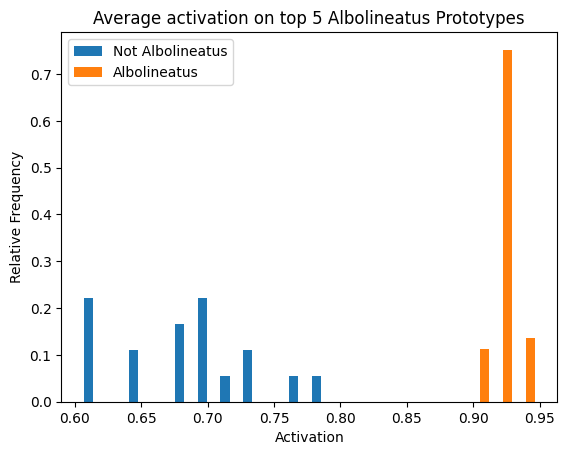

In [348]:
s = [[], []]

for sample in validation_dataset:
    o = get_corresponding_strings(sample[0], 1, tensors, 0, best_prototypes)
    l = 0
    for p, i, a, p_2 in o[:5]:
        l += a/5
    s[1 if sample[1] == 1 else 0].append(l)



# Remove empty lists
w = [[1 / len(y) for x in y] for y in s if y]

# Plot histogram of activations
plt.hist([a for a in s if a], bins=20, weights=w, label=[str(i) for i in range(8)])

plt.title("Average activation on top 5 Albolineatus Prototypes")
plt.xlabel("Activation")
plt.ylabel("Relative Frequency")
plt.legend(["Not Albolineatus", "Albolineatus"])
pass

In [349]:
is_best_prototype_location = torch.zeros(CLASS_COUNT, 40*18)

for i in range(CLASS_COUNT):
    best_prototypes_for_class = best_prototypes[i]

    for ind, j in enumerate(best_prototypes_for_class):
        # is_best_prototype_location[i][j*18:(j+1)*18] = (10 - ind) / 10
        is_best_prototype_location[i][j*18:(j+1)*18] = 1

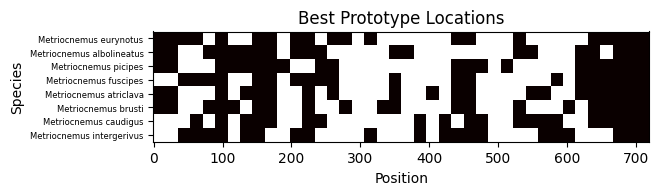

In [350]:
# Draw the heatmap
import matplotlib.pyplot as plt

classes = train_dataset.get_classes(TAXONOMY_NAME)[0]

plt.imshow(is_best_prototype_location, cmap='hot', interpolation='nearest')
plt.title("Best Prototype Locations")
plt.ylabel(TAXONOMY_NAME.capitalize())
plt.xlabel("Position")

# Set the y axis labels to the class names, make them diagonal
plt.yticks(range(CLASS_COUNT), classes)
# Decrease the y axis label font size
plt.yticks(fontsize=6)

# Make its aspect ratio 2:1
# plt.gca().set_aspect('auto', adjustable='box',)
plt.gca().set_aspect(20)
